In [1]:
import config_readwrite as crw
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from scipy import stats
import seaborn as sns
import statsmodels.api as sm
import sys

import warnings
warnings.filterwarnings("ignore")
from statsmodels.formula.api import ols

import plot_params as pp
pp.fonts()

('sans-serif', 'Arial', 18)

# config

In [2]:
CONFIG = "/wynton/home/ahituv/fongsl/EMF/config.ini"

config, cfn = crw.read(CONFIG)

RE = "/wynton/home/ahituv/fongsl/EMF/results/"
RE_DDCT = os.path.join(RE, f"*.ddCTs*.tsv")

# go to datapath
os.chdir(RE)

# load data 

In [3]:
fs = glob.glob(RE_DDCT)

results = {}
for f in fs:
    results[f] = pd.read_csv(f, sep='\t') 
    

In [4]:
fs

['/wynton/home/ahituv/fongsl/EMF/results/20240123.ddCTs.tsv',
 '/wynton/home/ahituv/fongsl/EMF/results/20231222.ddCTs.tsv',
 '/wynton/home/ahituv/fongsl/EMF/results/20231115.ddCTs.tsv',
 '/wynton/home/ahituv/fongsl/EMF/results/20231212.ddCTs.tsv',
 '/wynton/home/ahituv/fongsl/EMF/results/20240411.ddCTs.HOb.tsv']

In [5]:
df = pd.concat(results.values())
df = df.loc[~df["primers"].isna()]
df.head()

,Well Position,CT,plate,primers,sample_name,rep,Experiment,Control_mean,dCT,Control_dCT_mean,ddCT,fold_change,control_gene,date
0,B1,14.908525,plate1.xls,GAPDH,Control 30' exp1,1.0,1.0,26.109299,-11.200775,-11.398504,0.197730,0.871921,ACTB,20240123
1,B2,14.369675,plate1.xls,GAPDH,Control 30' exp1,2.0,1.0,26.109299,-11.739624,-11.398504,-0.341120,1.266740,ACTB,20240123
2,B3,15.763824,plate1.xls,GAPDH,Control 30' exp1,3.0,1.0,26.109299,-10.345476,-11.398504,1.053029,0.481955,ACTB,20240123
3,B4,13.756628,plate1.xls,GAPDH,PEMF 60' exp1,1.0,1.0,26.447333,-12.690705,-11.398504,-1.292200,2.449012,ACTB,20240123
4,B5,15.132206,plate1.xls,GAPDH,PEMF 60' exp1,2.0,1.0,26.447333,-11.315127,-11.398504,0.083378,0.943845,ACTB,20240123


## format data

In [6]:
# reformat some names

# 20231115
df.loc[(df["date"]==20231115)&
      (df["primers"] == "IL6"), "primers"] = "IL6-original"

df.loc[(df["date"]==20231115)&
      (df["sample_name"] == "PEMF-physiostim 60'"), "sample_name"] = "PEMF 60' exp1"

df.loc[(df["date"]==20231115)&
      (df["sample_name"] == "PEMF-physiostim 30'"), "sample_name"] = "PEMF 30' exp1"

df.loc[(df["date"]==20231115)&
      (df["sample_name"] == "Control"), "sample_name"] = "Control 30' exp1"

df.loc[df["primers"].str.contains("HSP1A1"), "primers"] = 'HSP70A'

# 20231212
df.loc[(df["date"]==20231212)&
      (df["primers"] == "IL6"), "primers"]="IL6-2"

df.loc[(df["date"]==20231212)&
      (df["sample_name"] == "PEMF-physiostim"), "sample_name"] = "PEMF 60' exp2"

df.loc[(df["date"]==20231212)&
      (df["sample_name"] == "Control"), "sample_name"] = "Control 60' exp2"

#20231222
df.loc[(df["date"]==20231222)&
      (df["sample_name"] == "PEMF-physiostim"), "sample_name"]="PEMF 60' exp2"

df.loc[(df["date"]==20231222)&
      (df["sample_name"] == "Control"), "sample_name"] = "Control 60' exp2"

#20240416
df.loc[(df["date"]==20240411)&
      (df["primers"] == "IL6"), "primers"] = "IL6-1"

# correct a blankspace issue
df.loc[df["primers"] == 'IL6-original ', "primers"] = 'IL6-original'

In [7]:
df[ "primers"].unique()

array(['GAPDH', 'IL6-original', 'ACTB', 'IL6-1', 'IL6-2', 'No rt - IL6-2',
       'HSP70A', 'empty', 'HSP70C', 'COL1A1', 'HSP70b', 'BGLAP', 'VEGF',
       'BMP2'], dtype=object)

# IL-6

In [8]:
genes = [#'IL6',
         'IL6-1',
         'IL6-2',
         'IL6-original'
        ]

il6 = df.loc[df["primers"].isin(genes)].copy()

il6.head()

il6[["sample_name", "date"]].drop_duplicates().sort_values(by='sample_name')

,sample_name,date
18,Control 30' exp1,20240123
96,Control 30' exp1,20231115
109,Control 60' exp2,20240123
108,Control 60' exp2,20231222
12,Control 60' exp2,20231212
36,Control 60' exp3,20240411
108,PEMF 30' exp1,20231115
120,PEMF 60' exp1,20231115
21,PEMF 60' exp1,20240123
15,PEMF 60' exp2,20231212


## ACTB housekeeping

IL6-1
IL6-2
IL6-original


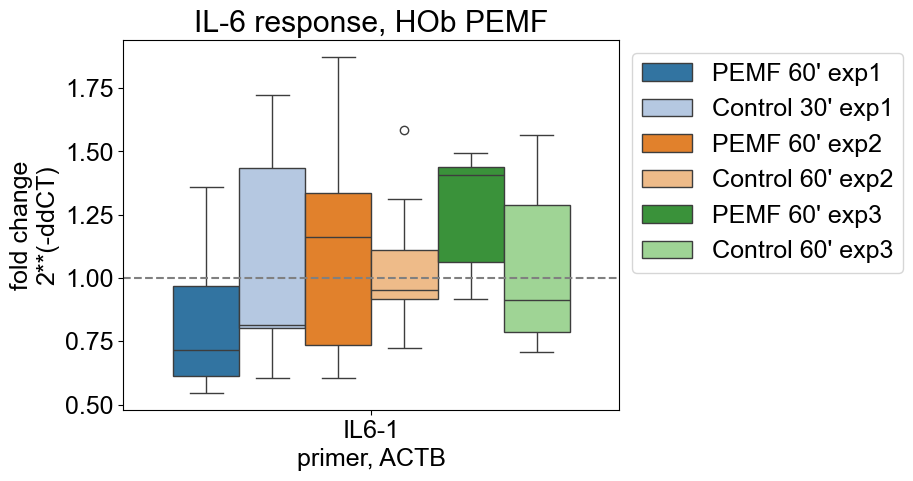

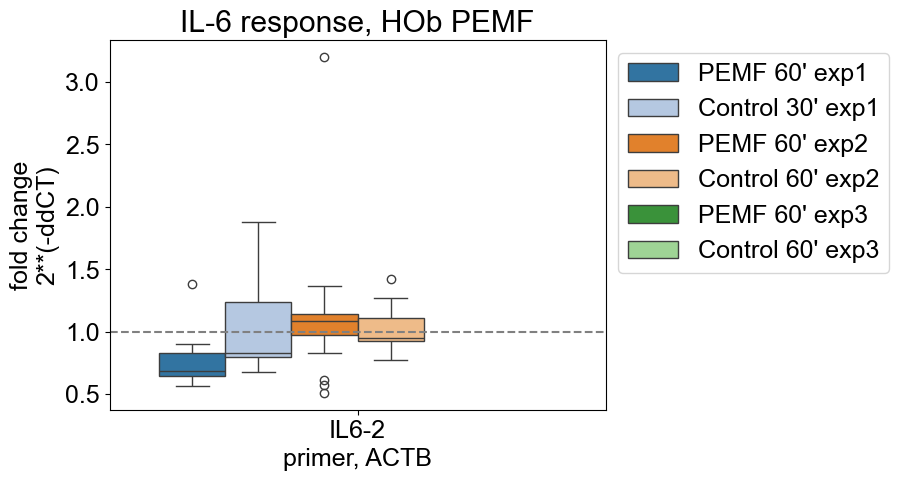

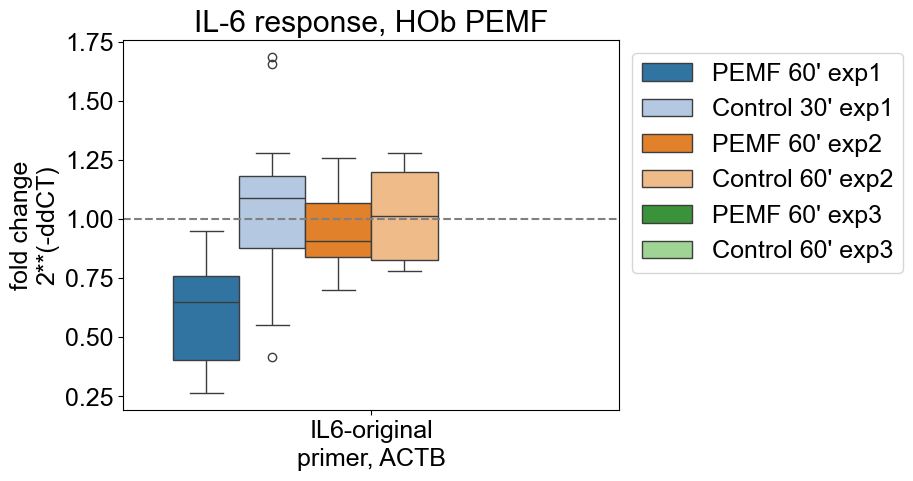

In [9]:
x = "primers"
y = "fold_change"
hue = 'sample_name'
control_gene = "ACTB"
hue_order = ["PEMF 60' exp1",
             "Control 30' exp1",
             "PEMF 60' exp2",
             "Control 60' exp2",
              "PEMF 60' exp3",
             "Control 60' exp3",
             ]


for gene in genes: 
    print(gene)
    data = il6.loc[(il6["control_gene"] == control_gene) &
                   (il6["sample_name"] != "noRT") &
                   (~il6["sample_name"].str.contains("HF")&
                   (il6["primers"]== gene))
                   ].copy()

    fig, ax = plt.subplots()
    sns.boxplot(x=x, y=y, data=data,
                hue=hue,
                hue_order=hue_order,
                # showfliers=False,
                palette="tab20"
                )
    ax.legend(frameon=False)
    """
    sns.swarmplot(x=x, y=y, data=data,
                  hue=hue,
                  hue_order=hue_order,
                  dodge=True,
                  palette="tab20",
                  linewidth=1,
                  size=4,
                  legend=False

                  )
                  """
    ax.axhline(1, ls="--", color="grey")
    ax.set(ylabel="fold change\n2**(-ddCT)",
           title='IL-6 response, HOb PEMF',
           xlabel=f"primer, {control_gene}")

    plt.legend(bbox_to_anchor=(1, 1))

    out = os.path.join(RE, f"qpcr_summary_{gene}_HOB_pemf_{control_gene}.pdf")
    plt.savefig(out, bbox_inches="tight")


## GAPDH house keeping

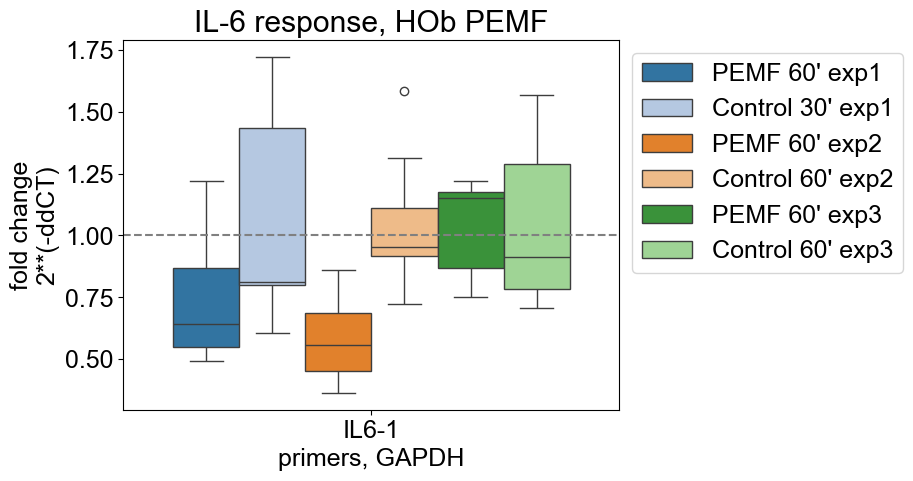

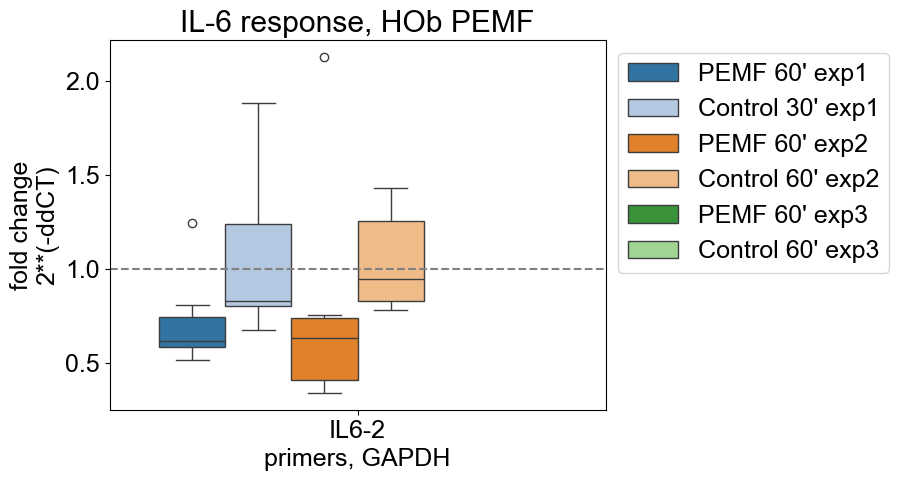

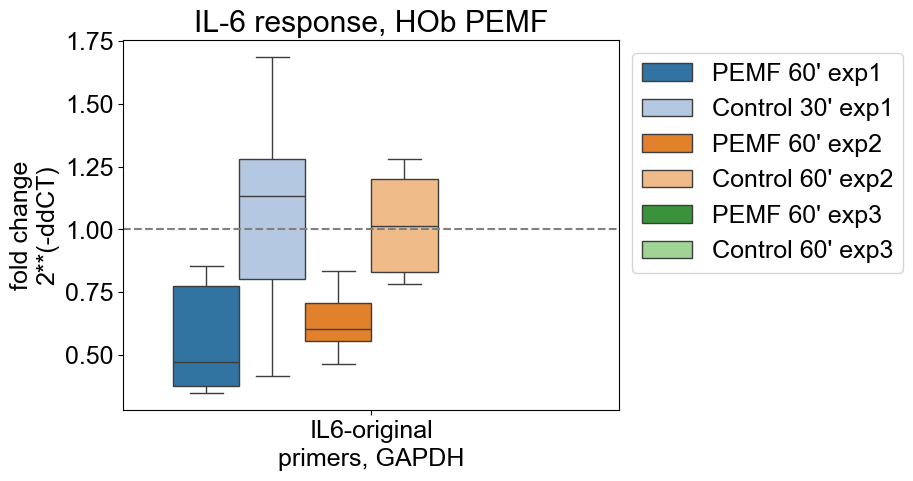

In [10]:
x = "primers"
y = "fold_change"
hue = 'sample_name'



control_gene = "GAPDH"
for gene in genes: 
    data = il6.loc[(il6["control_gene"] == control_gene) &
                   (il6["sample_name"] != "noRT") &
                   (~il6["sample_name"].str.contains("HF")&
                   (il6["primers"]== gene))
                   ].copy()

    fig, ax = plt.subplots()
    sns.boxplot(x=x, y=y, data=data,
                hue=hue,
                hue_order=hue_order,
                # showfliers=False,
                palette="tab20"
                )
    ax.legend(frameon=False)
    """
    sns.swarmplot(x=x, y=y, data=data,
                  hue=hue,
                  hue_order=hue_order,
                  dodge=True,
                  palette="tab20",
                  linewidth=1,
                  size=4,
                  legend=False

                  )
                  """
    ax.axhline(1, ls="--", color="grey")
    ax.set(ylabel="fold change\n2**(-ddCT)",
           title='IL-6 response, HOb PEMF',
           xlabel=f"primers, {control_gene}")

    plt.legend(bbox_to_anchor=(1, 1))

    out = os.path.join(RE, f"qpcr_summary_{gene}_HOB_pemf_{control_gene}.pdf")
    plt.savefig(out, bbox_inches="tight")

## all together 

In [11]:
# make a palette
palette = ["#0485d1", "#929591", "#75bbfd", "#d8dcd6", "#d0fefe", "#d8dcd6"]
sns.set_style("white")

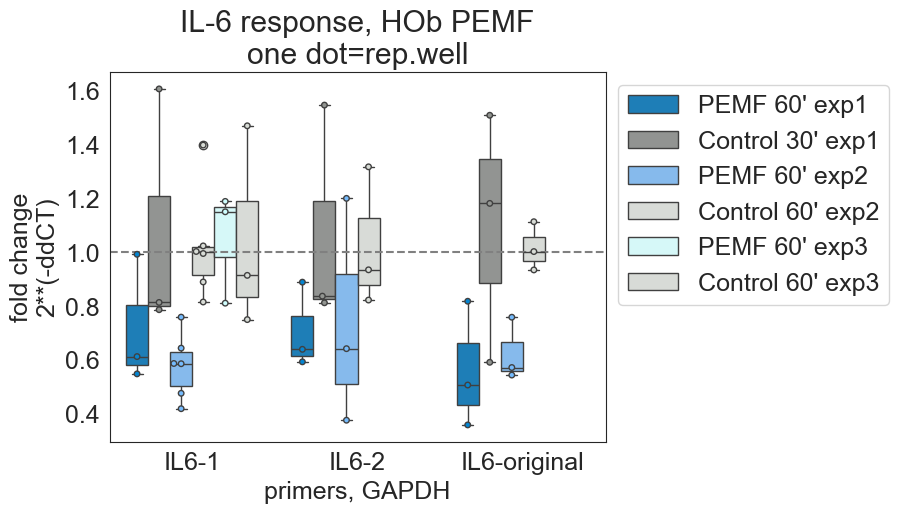

In [23]:
x = "primers"
y = "fold_change"
hue = 'sample_name'
SHOW_TECHNICAL_REPS = False

control_gene = "GAPDH"

data = il6.loc[(il6["control_gene"] == control_gene) &
               (il6["sample_name"] != "noRT") &
               (~il6["sample_name"].str.contains("HF"))
               ].copy()

if SHOW_TECHNICAL_REPS is False:
    # take the mean fold_change of technical replicates for each experiment, replicate, date
    data = data.groupby(["sample_name", "Experiment", 'rep', "date", "primers"])[
    "fold_change"].mean().reset_index()

fig, ax = plt.subplots()
sns.boxplot(x=x, y=y, data=data,
            hue=hue,
            hue_order=hue_order,
            # showfliers=False,
            palette=palette,
            )
ax.legend(frameon=False)

sns.swarmplot(x=x, y=y, data=data,
              hue=hue,
              hue_order=hue_order,
              dodge=True,
              palette=palette,
              linewidth=1,
              size=4,
              legend=False

              )

ax.axhline(1, ls="--", color="grey")

plt.legend(bbox_to_anchor=(1, 1))

if SHOW_TECHNICAL_REPS is False:
    ax.set(ylabel="fold change\n2**(-ddCT)",
       title='IL-6 response, HOb PEMF\none dot=rep.well',
       xlabel=f"primers, {control_gene}")

    out = os.path.join(
        RE, f"qpcr_summary_all-IL6_HOB_pemf_{control_gene}.bioreps.pdf")
else:
    ax.set(ylabel="fold change\n2**(-ddCT)",
       title='IL-6 response, HOb PEMF\none dot=rep.qpcr',
       xlabel=f"primers, {control_gene}")
    out = os.path.join(RE, f"qpcr_summary_all-IL6_HOB_pemf_{control_gene}.techreps.pdf")
    
plt.savefig(out, bbox_inches="tight")

In [13]:
for gene_name in genes:
    v=0
    for i in np.arange(len(hue_order)/2):
        
        # get the names of the control and test experiments
        ctrl, test = hue_order[(v+1)], hue_order[v]


        ctrl1 = data.loc[(data["sample_name"] == ctrl) &
                         (data["primers"] == gene_name),
                         "fold_change"]

        pemf1 = data.loc[(data["sample_name"] == test) &
                         (data["primers"] == gene_name),
                         "fold_change"]
   
        if len(ctrl1) > 0:
            s1, p1 = stats.mannwhitneyu(ctrl1,pemf1)
            print(gene_name, f"{ctrl}", s1, p1)
        v+=2


IL6-1 Control 30' exp1 7.0 0.4
IL6-1 Control 60' exp2 36.0 0.0021645021645021645
IL6-1 Control 60' exp3 4.0 1.0
IL6-2 Control 30' exp1 7.0 0.4
IL6-2 Control 60' exp2 7.0 0.4
IL6-original Control 30' exp1 8.0 0.2
IL6-original Control 60' exp2 9.0 0.1


# no RT

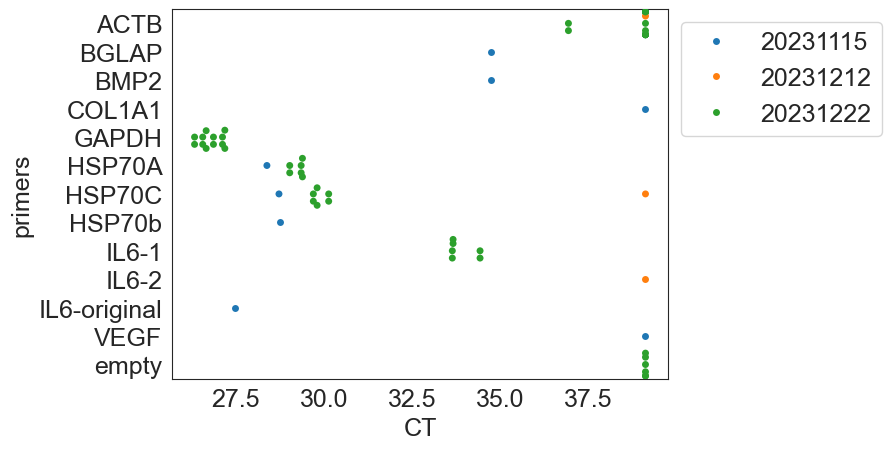

In [14]:
no_rt = df.loc[(df["sample_name"] == "noRT") ].copy()
no_rt["CT"] =no_rt["CT"].fillna(no_rt["CT"].max())
sns.swarmplot(y= "primers",x="CT", hue='date', data=no_rt.sort_values(by="primers"), palette="tab10")
plt.legend(bbox_to_anchor=(1,1))

# HSPs

In [15]:
genes = ["HSP70A", "HSP70C"]

hsp = df.loc[df["primers"].isin(genes)].copy()


hsp[["sample_name", "date"]].drop_duplicates().sort_values(by='sample_name')

,sample_name,date
6,Control 30' exp1,20231115
48,Control 60' exp2,20231222
48,Control 60' exp2,20231212
42,Control 60' exp3,20240411
18,PEMF 30' exp1,20231115
30,PEMF 60' exp1,20231115
51,PEMF 60' exp2,20231222
51,PEMF 60' exp2,20231212
45,PEMF 60' exp3,20240411
54,PEMF-HF-physiostim,20231212


## actb

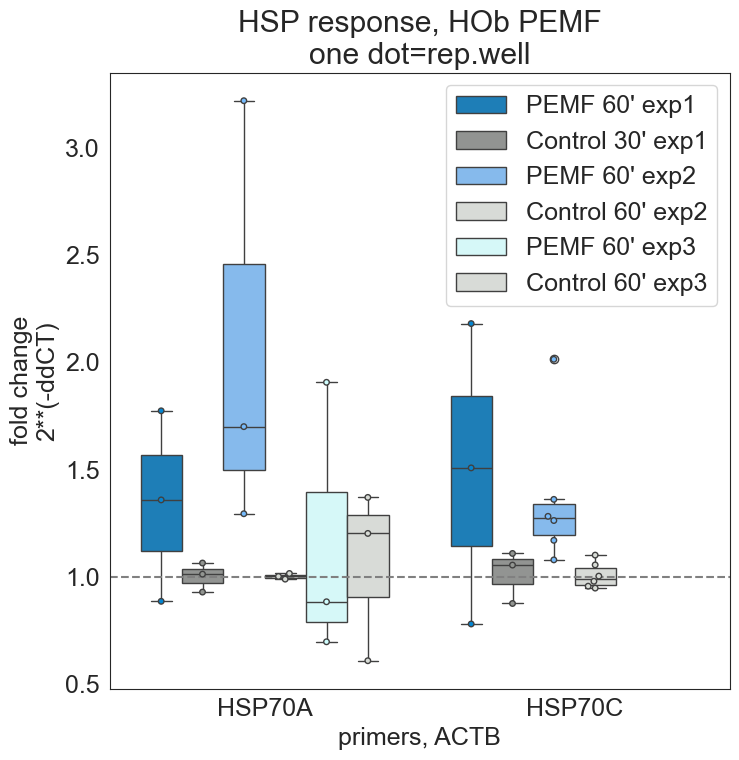

In [24]:
x = "primers"
y = "fold_change"
hue = 'sample_name'

SHOW_TECHNICAL_REPS = False


control_gene = "ACTB"
data = hsp.loc[(hsp["control_gene"] == control_gene) &
               (hsp["sample_name"] != "noRT") &
               (~hsp["sample_name"].str.contains("HF"))
               ].copy()


if SHOW_TECHNICAL_REPS is False:
    # take the mean fold_change of technical replicates for each experiment, replicate, date
    data = data.groupby(["sample_name", "Experiment", 'rep', "date", "primers"])[
    "fold_change"].mean().reset_index()

fig, ax = plt.subplots(figsize=(8,8))
sns.boxplot(x=x, y=y, data=data,
            hue=hue,
            hue_order=hue_order,
            # showfliers=False,
            palette=palette
            )
ax.legend(frameon=False)

sns.swarmplot(x=x, y=y, data=data,
              hue=hue,
              hue_order=hue_order,
              dodge=True,
              palette=palette,
              linewidth=1,
              size=4,
              legend=False

              )

ax.axhline(1, ls="--", color="grey")

plt.legend(bbox_to_anchor=(1, 1))
if SHOW_TECHNICAL_REPS is False:
    ax.set(ylabel="fold change\n2**(-ddCT)",
       title='HSP response, HOb PEMF\none dot=rep.well',
       xlabel=f"primers, {control_gene}")

    out = os.path.join(
        RE, f"qpcr_summary_all-hsp_HOB_pemf_{control_gene}.bioreps.pdf")
else:
    ax.set(ylabel="fold change\n2**(-ddCT)",
       title='HSP response, HOb PEMF\none dot=rep.qpcr',
       xlabel=f"primers, {control_gene}")
    out = os.path.join(RE, f"qpcr_summary_all-hsp_HOB_pemf_{control_gene}.techreps.pdf")


plt.savefig(out, bbox_inches="tight")

## test significance of ctrl v. test fold_changes

In [17]:
for gene_name in genes:
    v=0
    for i in np.arange(len(hue_order)/2):
        
        # get the names of the control and test experiments
        ctrl, test = hue_order[(v+1)], hue_order[v]


        ctrl1 = data.loc[(data["sample_name"] == ctrl) &
                         (data["primers"] == gene_name),
                         "fold_change"]

        pemf1 = data.loc[(data["sample_name"] == test) &
                         (data["primers"] == gene_name),
                         "fold_change"]
   
        if len(ctrl1) > 0:
            s1, p1 = stats.mannwhitneyu(ctrl1,pemf1)
            print(gene_name, f"{ctrl}", s1, p1)
        v+=2


HSP70A Control 30' exp1 3.0 0.7
HSP70A Control 60' exp2 0.0 0.1
HSP70A Control 60' exp3 4.0 1.0
HSP70C Control 30' exp1 3.0 0.7
HSP70C Control 60' exp2 1.0 0.004329004329004329


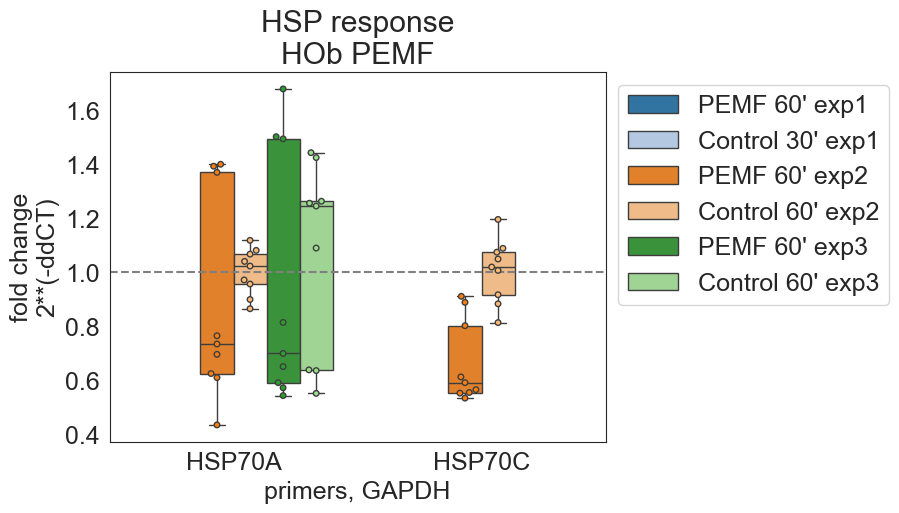

In [18]:
x = "primers"
y = "fold_change"
hue = 'sample_name'

control_gene = "GAPDH"
data = hsp.loc[(hsp["control_gene"] == control_gene) &
               (hsp["sample_name"] != "noRT") &
               (~hsp["sample_name"].str.contains("HF"))
               ].copy()

fig, ax = plt.subplots()
sns.boxplot(x=x, y=y, data=data,
            hue=hue,
            hue_order=hue_order,
            # showfliers=False,
            palette="tab20"
            )
ax.legend(frameon=False)

sns.swarmplot(x=x, y=y, data=data,
              hue=hue,
              hue_order=hue_order,
              dodge=True,
              palette="tab20",
              linewidth=1,
              size=4,
              legend=False

              )

ax.axhline(1, ls="--", color="grey")
ax.set(ylabel="fold change\n2**(-ddCT)",
       title='HSP response\nHOb PEMF', 
      xlabel=f"primers, {control_gene}")

plt.legend(bbox_to_anchor=(1, 1))

out = os.path.join(RE, f"qpcr_summary_hsp_HOB_pemf_{control_gene}.pdf")
plt.savefig(out, bbox_inches="tight")

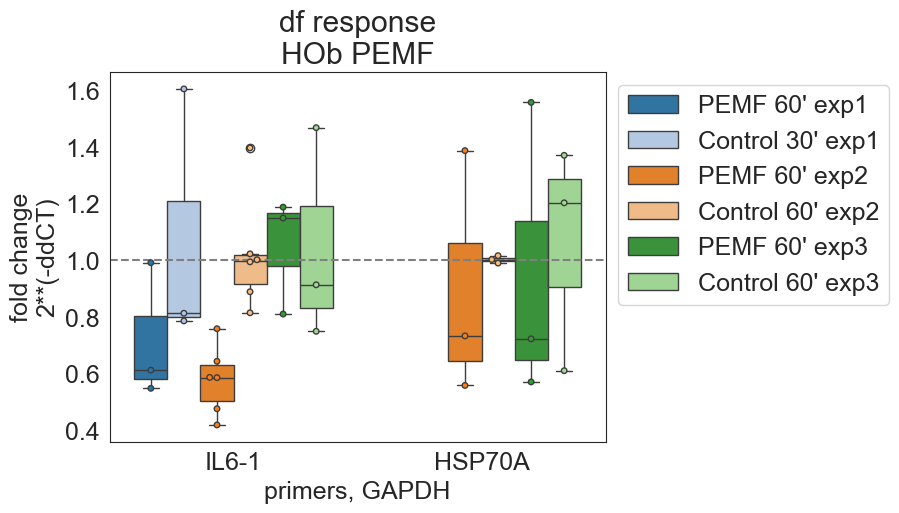

In [40]:
order =["IL6-1", "HSP70A"]

x = "primers"
y = "fold_change"
hue = 'sample_name'

control_gene = "GAPDH"

SHOW_TECHNICAL_REPS = False
data = df.loc[(df["control_gene"] == control_gene) &
               (df["sample_name"] != "noRT") &
               (~df["sample_name"].str.contains("HF")&
               (df["primers"].isin(order)))
               ].copy()

if SHOW_TECHNICAL_REPS is False:
    # take the mean fold_change of technical replicates for each experiment, replicate, date
    data = data.groupby(["sample_name", "Experiment", 'rep', "date", "primers"])[
    "fold_change"].mean().reset_index()

fig, ax = plt.subplots()
sns.boxplot(x=x, y=y, data=data,
            hue=hue,
            order=order, 
            hue_order=hue_order,
            # showfliers=False,
            palette="tab20"
            )
ax.legend(frameon=False)

sns.swarmplot(x=x, y=y, data=data,
              hue=hue,
              order=order, 
              hue_order=hue_order,
              dodge=True,
              palette="tab20",
              linewidth=1,
              size=4,
              legend=False

              )

ax.axhline(1, ls="--", color="grey")
ax.set(ylabel="fold change\n2**(-ddCT)",
       title='df response\nHOb PEMF', 
      xlabel=f"primers, {control_gene}")

plt.legend(bbox_to_anchor=(1, 1))

out = os.path.join(RE, f"qpcr_summary_df_HOB_pemf_{control_gene}.pdf")
plt.savefig(out, bbox_inches="tight")

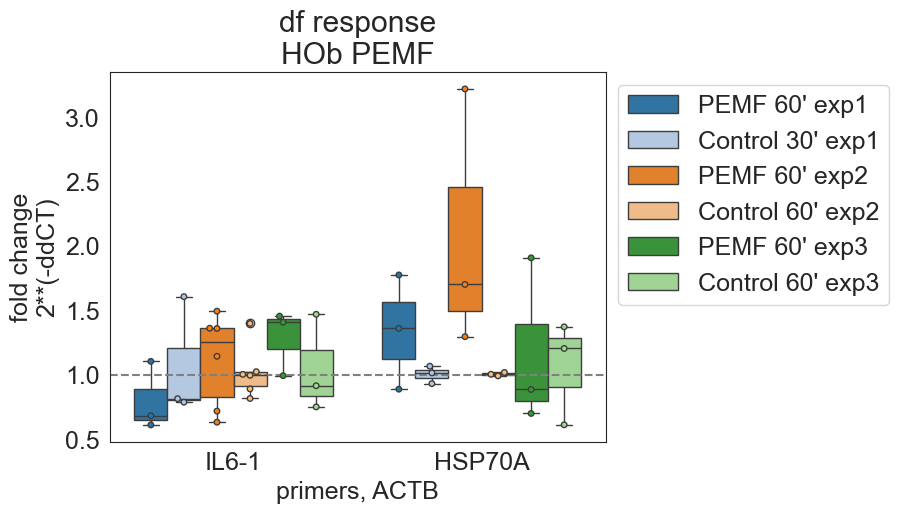

In [39]:
order =["IL6-1", "HSP70A"]

x = "primers"
y = "fold_change"
hue = 'sample_name'

control_gene = "ACTB"

SHOW_TECHNICAL_REPS= False
data = df.loc[(df["control_gene"] == control_gene) &
               (df["sample_name"] != "noRT") &
               (~df["sample_name"].str.contains("HF")&
               (df["primers"].isin(order)))
               ].copy()
if SHOW_TECHNICAL_REPS is False:
    # take the mean fold_change of technical replicates for each experiment, replicate, date
    data = data.groupby(["sample_name", "Experiment", 'rep', "date", "primers"])[
    "fold_change"].mean().reset_index()

fig, ax = plt.subplots()
sns.boxplot(x=x, y=y, data=data,
            hue=hue,
            order=order, 
            hue_order=hue_order,
            # showfliers=False,
            palette="tab20"
            )
ax.legend(frameon=False)

sns.swarmplot(x=x, y=y, data=data,
              hue=hue,
              order=order, 
              hue_order=hue_order,
              dodge=True,
              palette="tab20",
              linewidth=1,
              size=4,
              legend=False

              )

ax.axhline(1, ls="--", color="grey")
ax.set(ylabel="fold change\n2**(-ddCT)",
       title='df response\nHOb PEMF', 
      xlabel=f"primers, {control_gene}")

plt.legend(bbox_to_anchor=(1, 1))

out = os.path.join(RE, f"qpcr_summary_df_HOB_pemf_{control_gene}.pdf")
plt.savefig(out, bbox_inches="tight")